
# How To Use Maskix

Maskix is our implementation of a variational autoencoder.  
This tutorial follows the structure of our `Getting Started - Vanillix`, but is much less extensive, because  
our pipeline works similarly for different architectures, so here we focus only on Maskix specifics.

**AUTOENCODIX** supports far more functionality than shown here, so we’ll also point to advanced tutorials where relevant.  

**IMPORTANT**

> This tutorial only shows the specifics of the Maskix pipeline. If you're unfamiliar with general concepts,  
> we recommend following the `Getting Started - Vanillix` tutorial first.

## What You'll Learn

You’ll learn how to:

1. **Theory primer** of the Maskix architecture. <br><br>
2. **Initialize** the pipeline and run the pipeline. <br><br>
3. Understand Maskix-specific **config parameters*. <br><br>
4. **Access & Visualize** the results effectively. <br><br>
5. Pass **custom masking fucntions**. <br><br>
6. How to use Maskix for **data imputation** <br><br>
7. **Save, load, and reuse** a trained pipeline. <br><br>


## 1) Theory Primer

Maskix adapts the scMAE (single-cell Masked Autoencoder) framework from Fang et al. (2024) for single-cell RNA-seq analysis. The model learns useful representations by corrupting the input expression matrix and training the network both to reconstruct the original data and to identify which entries were perturbed. This encourages the model to capture gene–gene (or feature–feature) relationships in high-dimensional, noisy datasets. Although originally designed for single-cell data, the same approach applies to other domains.

Each training iteration follows this corruption process:

1. Sample a Bernoulli distribution to determine which entries should be perturbed, producing a binary mask with the same shape as the input.
2. For each gene (or feature), generate a random permutation of sample indices.
3. For all positions marked as masked, replace the original value with the value from the permuted index for that feature.

The corrupted input is encoded into a low-dimensional latent representation. In parallel, a mask predictor takes the latent space as input and estimates which positions were masked. The predicted mask is then concatenated with the latent representation and passed into a decoder that attempts to reconstruct the original values.

Training uses two loss components. The mask predictor is optimized with binary cross-entropy against the true mask. Reconstruction uses a weighted mean-squared error where masked entries receive higher weight, controlled by the hyperparameter `delta_mask_corrupted`. The total loss is the weighted sum of these components, balanced by the hyperparameter `delta_mask_predictor`.


## Requirements 1: Be in the correct directory (execute below)


In [5]:
import os

p = os.getcwd()
d = "autoencodix_package"
if d not in p:
    raise FileNotFoundError(f"'{d}' not found in path: {p}")
os.chdir(os.sep.join(p.split(os.sep)[: p.split(os.sep).index(d) + 1]))
print(f"Changed to: {os.getcwd()}")

Changed to: /Users/maximilianjoas/development/autoencodix_package


## Requirements 2: Obtain tutorial data or use own data
We use a dataset from the [Fang et al. (2024)](https://doi.org/10.1093/bioinformatics/btae020), with can be donwloaded [here](https://cloud.scadsai.uni-leipzig.de/index.php/s/BP8YzDef4nSfgwj/download/GSE84133_human_combined_final.h5ad), this needs to be moved to `data/raw`. Alternatively you can use your own single-cell dataset (Maskix works with other datatypes, but in this example we expect single cell data: `h5ad`) file and replace the variable `sc_path`.


## 2) Initialize and Run Maskix
As for every other pipline, we need to perform the following steps:
- import relevant classes
- define a config
- init the pipeline
- call the run step

In [6]:
import autoencodix as acx
from autoencodix.configs import MaskixConfig
from autoencodix.configs.default_config import DataInfo, DataConfig, DataCase

sc_path = os.path.join("data/raw", "GSE84133_human_combined_final.h5ad")
config = MaskixConfig(
    epochs=30,
    checkpoint_interval=10,
    k_filter=1000,
    batch_size=64,
    data_config=DataConfig(
        annotation_columns=["multi_sc:assigned_cluster"],
        data_info={
            "multi_sc": DataInfo(
                file_path=sc_path, is_single_cell=True, data_type="NUMERIC"
            )
        },
    ),
    data_case=DataCase.MULTI_SINGLE_CELL,
)
maskix = acx.Maskix(config=config)

In [7]:
maskix_result = maskix.run()

Number of common cells: 8569
Index(['barcode', 'assigned_cluster', 'sample_id'], dtype='object')
mudata: View of MuData object with n_obs × n_vars = 8569 × 20125
  obs:	'barcode', 'assigned_cluster', 'sample_id'
  1 modality
    multi_sc:	8569 x 20125
      obs:	'barcode', 'assigned_cluster', 'sample_id'
Processing 1 MuData objects: ['multi_sc']
Processing train modality: multi_sc
Processing valid split
Processing valid modality: multi_sc
Processing test split
Processing test modality: multi_sc


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/losses/maskix_loss.py:38: UserWarning: You chose loss reduction: sum, this deviates from the implementation in the literature for this architecture, the authors used 'mean'
  warnings.warn(


Epoch 1 - Train Loss: 453.3005
Sub-losses: recon_loss: 324.5980, mask_loss: 508.4587
Epoch 1 - Valid Loss: 371.2240
Sub-losses: recon_loss: 341.3466, mask_loss: 384.0285
Epoch 2 - Train Loss: 361.7743
Sub-losses: recon_loss: 316.1668, mask_loss: 381.3204
Epoch 2 - Valid Loss: 360.2993
Sub-losses: recon_loss: 321.1397, mask_loss: 377.0820
Epoch 3 - Train Loss: 356.8079
Sub-losses: recon_loss: 305.0824, mask_loss: 378.9760
Epoch 3 - Valid Loss: 358.8477
Sub-losses: recon_loss: 315.7664, mask_loss: 377.3111
Epoch 4 - Train Loss: 354.7780
Sub-losses: recon_loss: 299.9821, mask_loss: 378.2620
Epoch 4 - Valid Loss: 356.1210
Sub-losses: recon_loss: 307.2420, mask_loss: 377.0691
Epoch 5 - Train Loss: 354.4414
Sub-losses: recon_loss: 298.7207, mask_loss: 378.3217
Epoch 5 - Valid Loss: 356.1020
Sub-losses: recon_loss: 309.6541, mask_loss: 376.0083
Epoch 6 - Train Loss: 353.3391
Sub-losses: recon_loss: 296.3589, mask_loss: 377.7592
Epoch 6 - Valid Loss: 356.4676
Sub-losses: recon_loss: 309.4295, 


## 3) Understanding Maskix-specific Config Parameters

As described in the [theory section](#1-theory-primer), we implemented the architecture from [Fang et al. (2024)](https://doi.org/10.1093/bioinformatics/btae020), with weighted loss terms and a specific encoder–decoder design. To make this adaptable within our framework, we expose the following configuration parameters:

* **maskix_hidden_dim**: Hidden dimension used in the Maskix encoder and decoder, matching the scMAE reference architecture by default.
* **maskix_swap_prob**: Bernoulli probability controlling how often feature values are swapped during input corruption.
* **delta_mask_predictor**: Weighting factor for the mask prediction loss in the total training objective.
* **delta_mask_corrupted**: Weighting factor that increases the reconstruction penalty on corrupted entries.
* **maskix_architecture**: Selects between the default scMAE architecture or a custom architecture configured through `n_layers` and `enc_factor`.

You can find the default values by running the following:


In [8]:
MaskixConfig.print_schema(
    filter_params=[
        "maskix_hidden_dim",
        "maskix_swap_prob",
        "delta_mask_predictor",
        "delta_mask_corrupted",
        "maskix_architecture",
    ]
)


Valid Keyword Arguments:
--------------------------------------------------

maskix_hidden_dim:
  Type: <class 'int'>
  Default: 128
  Description: The Maskix implementation follows https://doi.org/10.1093/bioinformatics/btae020. The authors use a hidden dimension 0f 256 for their neural network, so we set this as default

maskix_swap_prob:
  Type: <class 'float'>
  Default: 0.2
  Description: For the Maskix input_data masinkg, we sample a probablity if samples within one gene should be swapt. This is done with a Bernoulli distribution, maskix_swap_prob is the probablity passed to the bernoulli distribution 

delta_mask_predictor:
  Type: <class 'float'>
  Default: 0.7
  Description: Delt weighting factor of the mask predictin loss term for the Maskix

delta_mask_corrupted:
  Type: <class 'float'>
  Default: 0.75
  Description: For the Maskix: if >0.5 this gives more weight for the correct reconstruction of corrupted input

maskix_architecture:
  Type: typing.Literal['scMAE', 'custom']

## 4) Access & Visualize Results Effectively

In addition to the results that the Vanillix pipeline provided, we can access:
- `total`, `reconstruction`, and `masked` losses  

A note on the different loss types:  
For our maksed autoencoder, the total loss consists of a reconstruction loss and a mask predictor los
To investigate these losses, the `result` object has the attribute `sub_losses`.  
This is a `LossRegistry` with the name of the loss as the key, and the value is a `TrainingDynamics` object, which can be accessed in the same way as for the Vanillix results.

For more details, check `Tutorials/DeepDives/PipelineOutputTutorial.ipynb`.


In [9]:
sub_losses = maskix_result.sub_losses
print("Sub Losses:")
print(f"keys: {sub_losses.keys()}")
print("\n")
recon_dyn = sub_losses.get(key="recon_loss")
print("Value of reconstruction loss in epoch 4 for train split")
print(recon_dyn.get(split="train", epoch=4))

Sub Losses:
keys: dict_keys(['recon_loss', 'mask_loss'])


Value of reconstruction loss in epoch 4 for train split
298.72072754720324


As for our other pipelines we can visualize the loss with `.show_result()`
For more infos on visualization, see: `Tutorials/DeepDives/VisualizeTutorial.ipynb`

Creating plots ...


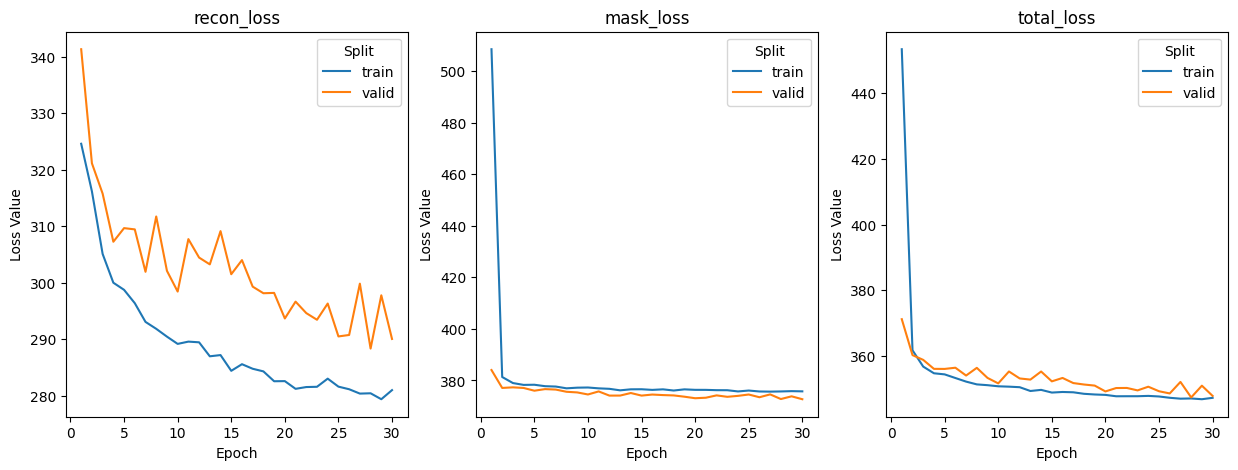

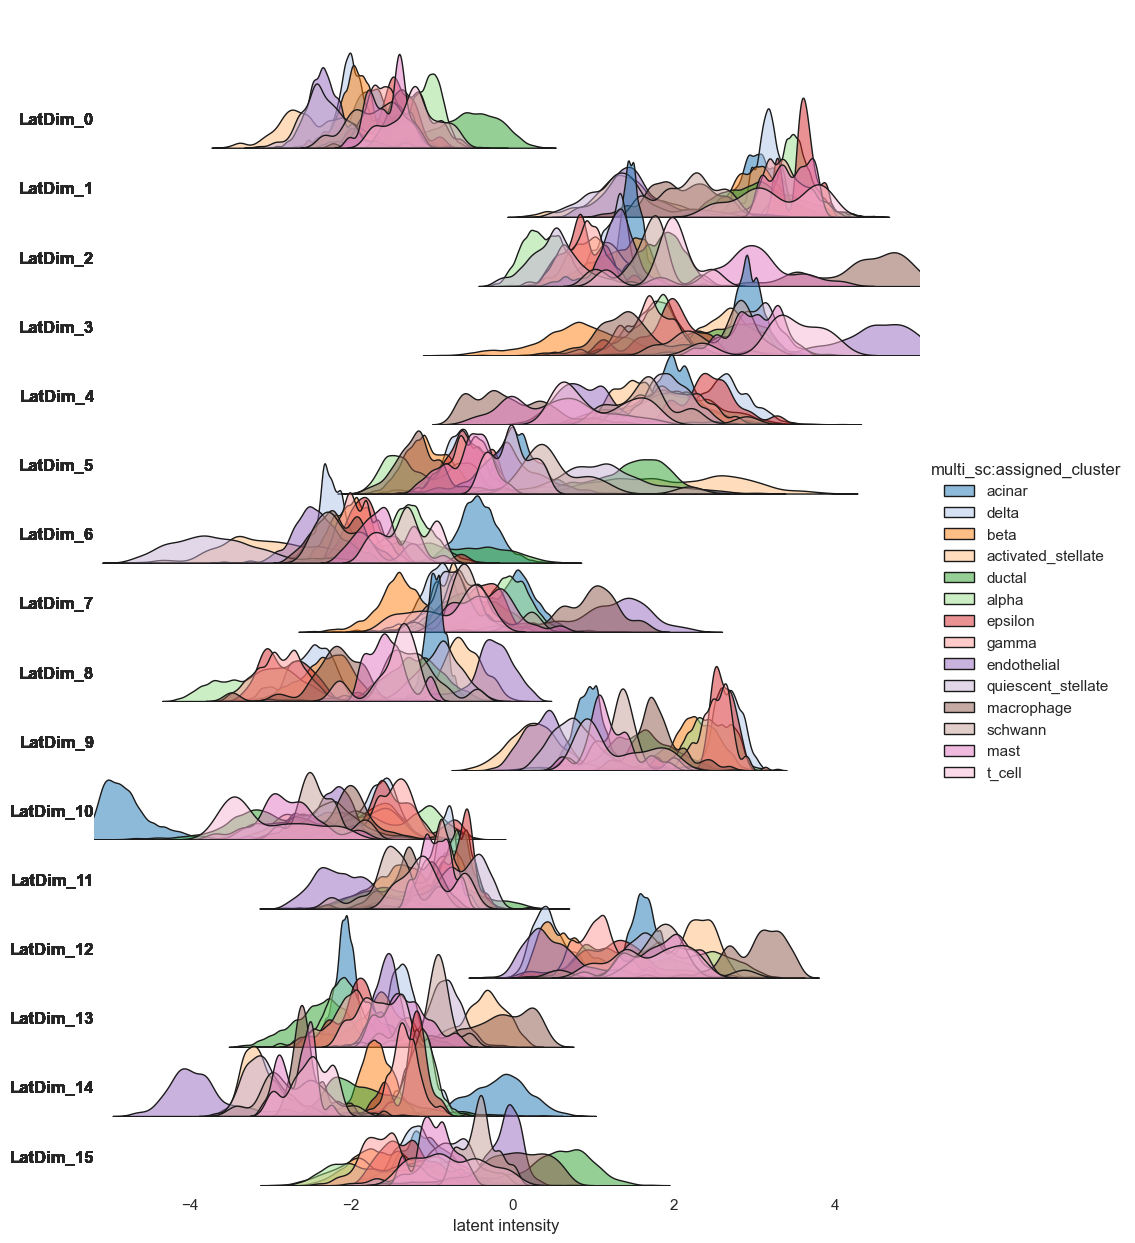

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


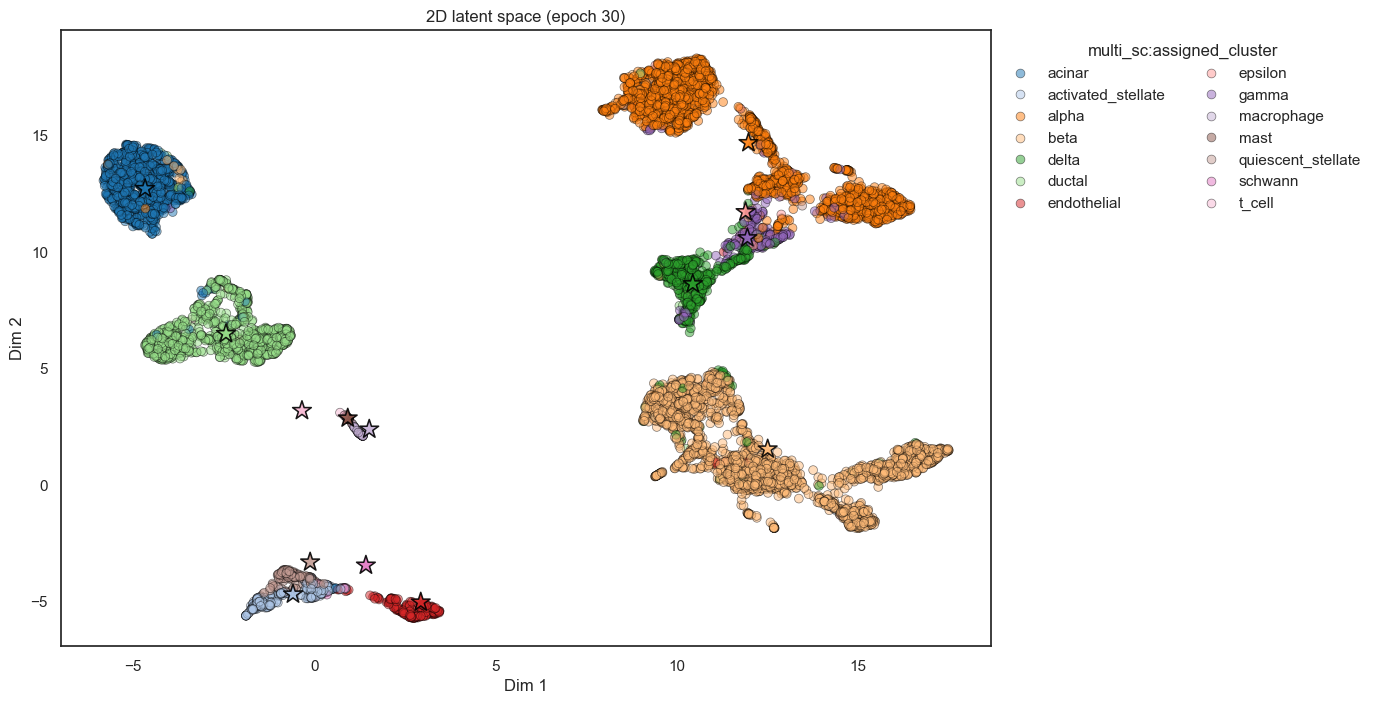

In [10]:
maskix.show_result()

## 5) Adding a Custom Masking Function to `MaskixTrainer`

`MaskixTrainer` supports replacing its default corruption mechanism with a user-defined masking function. This enables experimentation with alternative masking strategies while ensuring compatibility with the trainer’s data flow.

#### How to Add a Custom Masking Function

Provide your masking function at initialization:

```python
# We assume that config is defined and other imports are done (see above)

def my_masking_fn(x: torch.Tensor, strength: float = 0.2):
    noise = torch.randn_like(x) * strength
    return x + noise  # must return ONLY a single tensor in shape of input tensor

masking_fn_kwargs = {"strength": 0.1}
maskix = acx.Maskix(config=config, masking_fn, masking_fn_kwargs
)
```
#### Requirements for a Custom Masking Function

A custom masking function must satisfy the following constraints:

1. **It must accept a `torch.Tensor` as the first positional argument.**  
   The trainer passes the input mini-batch `X` directly into the function.

2. **It must return exactly one value: a `torch.Tensor`.**  
   The trainer does not consume or propagate additional outputs.  
   Returning tuples or multiple values is not allowed.

3. **The returned tensor must have the same shape as the input tensor.**  
   Any shape mismatch will raise a validation error.

4. **The function must operate on the device of the input tensor.**  
   The function must not assume the tensor resides on the CPU; it must operate on the device of `x`.

5. **Any additional parameters must be passed via `masking_fn_kwargs`.**  
   These keyword arguments provide a clean separation between trainer configuration and masking logic.

##### Example
This is our default masking method:
```python
    def _maskix_hook(
        self, X: torch.Tensor
    ) -> torch.Tensor
        # expand probablities for bernoulli sampling to match input shape
        probs = self._mask_probas.expand(X.shape)

        # Create the Boolean Mask (1 = Swap, 0 = Keep)
        should_swap = torch.bernoulli(probs).bool()

        # COLUMN-WISE SHUFFLING
        # We generate a random float matrix and argsort it along dim=0.
        # This gives us independent random indices for every column.
        rand_indices = torch.rand(X.shape, device=X.device).argsort(dim=0)

        # Use gather to reorder X based on these random indices
        shuffled_X = torch.gather(X, 0, rand_indices)
        corrupted_X = torch.where(should_swap, shuffled_X, X)

        return corrupted_X
```



##### Code Example

In [11]:
import torch
import autoencodix as acx
from autoencodix.configs import MaskixConfig
from autoencodix.configs.default_config import DataInfo, DataConfig, DataCase


def my_masking_fn(x: torch.Tensor, strength: float = 0.2):
    # Noise is created with the same shape, dtype, and device as `x`
    # Because of randn_lie, if you use other function, take care of 
    # device and dtype casting.
    noise = torch.randn_like(x) * strength
    return x + noise


kwargs = {"strength": 0.5}


sc_path = os.path.join("data/raw", "GSE84133_human_combined_final.h5ad")
config = MaskixConfig(
    epochs=5,
    checkpoint_interval=2,
    batch_size=64,
    data_config=DataConfig(
        annotation_columns=["multi_sc:assigned_cluster"],
        data_info={
            "multi_sc": DataInfo(
                file_path=sc_path, is_single_cell=True, data_type="NUMERIC"
            )
        },
    ),
    data_case=DataCase.MULTI_SINGLE_CELL,
)
maskix = acx.Maskix(config=config, masking_fn=my_masking_fn, masking_fn_kwargs=kwargs)

In [12]:
result = maskix.run()

Number of common cells: 8569
Index(['barcode', 'assigned_cluster', 'sample_id'], dtype='object')
mudata: View of MuData object with n_obs × n_vars = 8569 × 20125
  obs:	'barcode', 'assigned_cluster', 'sample_id'
  1 modality
    multi_sc:	8569 x 20125
      obs:	'barcode', 'assigned_cluster', 'sample_id'
Processing 1 MuData objects: ['multi_sc']
Processing train modality: multi_sc
Processing valid split
Processing valid modality: multi_sc
Processing test split
Processing test modality: multi_sc


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/losses/maskix_loss.py:38: UserWarning: You chose loss reduction: sum, this deviates from the implementation in the literature for this architecture, the authors used 'mean'
  warnings.warn(


Epoch 1 - Train Loss: 12086.9782
Sub-losses: recon_loss: 12926.3007, mask_loss: 11727.2686
Epoch 1 - Valid Loss: 14527.6513
Sub-losses: recon_loss: 21107.4393, mask_loss: 11707.7422
Epoch 2 - Train Loss: 12016.2973
Sub-losses: recon_loss: 12790.4406, mask_loss: 11684.5216
Epoch 2 - Valid Loss: 14497.0561
Sub-losses: recon_loss: 21084.0808, mask_loss: 11674.0456
Epoch 3 - Train Loss: 11990.0615
Sub-losses: recon_loss: 12758.4863, mask_loss: 11660.7365
Epoch 3 - Valid Loss: 14480.5854
Sub-losses: recon_loss: 21087.1386, mask_loss: 11649.2055
Epoch 4 - Train Loss: 11972.5585
Sub-losses: recon_loss: 12748.6290, mask_loss: 11639.9567
Epoch 4 - Valid Loss: 14479.4724
Sub-losses: recon_loss: 21155.1894, mask_loss: 11618.4508
Epoch 5 - Train Loss: 11963.3196
Sub-losses: recon_loss: 12743.7401, mask_loss: 11628.8535
Epoch 5 - Valid Loss: 14467.4802
Sub-losses: recon_loss: 21066.2140, mask_loss: 11639.4512


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/visualize/_general_visualizer.py:34: UserWarning: Model weights plot is skipped since input dimension 17258 is larger than 3000 and heatmap would be too large.
  warnings.warn(


## 6) Use Maskix to Impute Data

You can also input corrupted/missing data and use `Maskix` to impute the data. Here we recommend using a custom masking function. For example, if you want to impute missing values, an imputer could randomly replace values with zeros.

Then you could use `Maskix` to clean your data and use the cleaned data to run your analysis, for example another autoencodix pipeline or anything else. In our mock example we will do the following:

- Create corrupted data with missing values
- Remove the "missing" data
- Train Maskix with clean data, but with a custom imputer that mimics missing data
- Feed corrupted data into trained Maskix and obtain imputed data
- Train Varix with:
    - Original data with missing values
    - Imputed data
- Compare results

#### Create Corrupted Data
We will use our single-cell example from before and use maskix to preprocess the data, which makes the artificall corruption process more robust, because we make sure to corrupt informative features/samples.

##

In [13]:
import torch
import autoencodix as acx
from autoencodix.configs import MaskixConfig
from autoencodix.configs.default_config import DataInfo, DataConfig, DataCase


sc_path = os.path.join("data/raw", "GSE84133_human_combined_final.h5ad")
config = MaskixConfig(
    epochs=30,
    checkpoint_interval=2,
    k_filter=1000,
    batch_size=64,
    data_config=DataConfig(
        annotation_columns=["multi_sc:assigned_cluster"],
        data_info={
            "multi_sc": DataInfo(
                file_path=sc_path, is_single_cell=True, data_type="NUMERIC"
            )
        },
    ),
    data_case=DataCase.MULTI_SINGLE_CELL,
)
maskix_orig = acx.Maskix(config=config)
maskix_orig.preprocess()
data = maskix_orig.result.datasets

Number of common cells: 8569
Index(['barcode', 'assigned_cluster', 'sample_id'], dtype='object')
mudata: View of MuData object with n_obs × n_vars = 8569 × 20125
  obs:	'barcode', 'assigned_cluster', 'sample_id'
  1 modality
    multi_sc:	8569 x 20125
      obs:	'barcode', 'assigned_cluster', 'sample_id'
Processing 1 MuData objects: ['multi_sc']
Processing train modality: multi_sc
Processing valid split
Processing valid modality: multi_sc
Processing test split
Processing test modality: multi_sc


Now we will randomly set data do zero with.

In [14]:

import torch
import copy
from autoencodix.data._numeric_dataset import NumericDataset
def drop_samples(ds: NumericDataset):
    """Randomly drops samples in .data and according .metadata (pd.DataFrame) and sample_ids"""
    data = ds.data
    n_samples = data.shape[0]
    drop_prob = 0.3
    keep_mask = torch.bernoulli((1 - drop_prob) * torch.ones(n_samples)).bool()
    # replace entries with zero
    imputed_data = data.clone()
    imputed_data[~keep_mask] = 0

    missing_data = data[keep_mask]
    missing_metadata = ds.metadata.iloc[keep_mask.cpu().numpy()].reset_index(drop=True)
    missing_sample_ids = [sid for i, sid in enumerate(ds.sample_ids) if keep_mask[i]]
    ds_with_missing = copy.deepcopy(ds)
    ds_with_missing.data = missing_data
    ds_with_missing.metadata = missing_metadata
    ds_with_missing.sample_ids = missing_sample_ids


    ds_with_zero = copy.deepcopy(ds)
    ds_with_zero.data = imputed_data
    ds_with_zero.metadata = ds.metadata
    ds_with_zero.sample_ids = ds.sample_ids
    return ds_with_missing, ds_with_zero

ds_with_missing = copy.deepcopy(data)
ds_with_zero = copy.deepcopy(data)
missing_train, ds_with_zero_train = drop_samples(ds_with_missing.train)

print(f"Original train data shape: {data.train.data.shape}, shape after corruption: {missing_train.data.shape}")
missing_test, ds_with_zero_test = drop_samples(data.test)
print(f"Original test data shape: {data.test.data.shape}, shape after corruption: {missing_test.data.shape}")
missing_valid, ds_with_zero_valid    = drop_samples(data.valid)
print(f"Original valid data shape: {data.valid.data.shape}, shape after corruption: {missing_valid.data.shape}")
ds_with_missing.train= missing_train
ds_with_missing.test = missing_test
ds_with_missing.valid = missing_valid


ds_with_zero.train= ds_with_zero_train
ds_with_zero.test = ds_with_zero_test
ds_with_zero.valid = ds_with_zero_valid
# clean corruped samples by removing zero values from dataset (drop samples) and also 




Original train data shape: torch.Size([5998, 1000]), shape after corruption: torch.Size([4195, 1000])
Original test data shape: torch.Size([1715, 1000]), shape after corruption: torch.Size([1214, 1000])
Original valid data shape: torch.Size([856, 1000]), shape after corruption: torch.Size([607, 1000])


Now we train our Maskix with this clean data, but we will pass a custom imputer that will simulate missing values

In [15]:
import torch
import autoencodix as acx
from autoencodix.configs import MaskixConfig
from autoencodix.configs.default_config import DataInfo, DataConfig, DataCase


def my_imputer(x: torch.Tensor) -> torch.Tensor:
    "randomly replaces value with zero"
    rand_mask = torch.bernoulli(0.3 * torch.ones(x.shape, device=x.device)).bool()
    rand_mask.to(x.device)
    imputed_x = torch.where(rand_mask, torch.zeros_like(x, device=x.device), x)
    return imputed_x


sc_path = os.path.join("data/raw", "GSE84133_human_combined_final.h5ad")
config = MaskixConfig(
    epochs=30,
    checkpoint_interval=2,
    k_filter=3000,
    skip_preprocessing=True,
    batch_size=64,
    data_config=DataConfig(
        annotation_columns=["multi_sc:assigned_cluster"],
        data_info={
            "multi_sc": DataInfo(
                 is_single_cell=True, data_type="NUMERIC"
            )
        },
    ),
    data_case=DataCase.MULTI_SINGLE_CELL,
)
maskix = acx.Maskix(config=config, masking_fn=my_imputer, data=ds_with_missing)
result = maskix.run()

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/losses/maskix_loss.py:38: UserWarning: You chose loss reduction: sum, this deviates from the implementation in the literature for this architecture, the authors used 'mean'
  warnings.warn(


Epoch 1 - Train Loss: 566.8874
Sub-losses: recon_loss: 361.5831, mask_loss: 654.8750
Epoch 1 - Valid Loss: 546.1885
Sub-losses: recon_loss: 383.5735, mask_loss: 615.8806
Epoch 2 - Train Loss: 533.5137
Sub-losses: recon_loss: 346.5822, mask_loss: 613.6272
Epoch 2 - Valid Loss: 541.0129
Sub-losses: recon_loss: 373.0861, mask_loss: 612.9815
Epoch 3 - Train Loss: 530.1418
Sub-losses: recon_loss: 337.5454, mask_loss: 612.6831
Epoch 3 - Valid Loss: 538.0347
Sub-losses: recon_loss: 362.6035, mask_loss: 613.2194
Epoch 4 - Train Loss: 528.4645
Sub-losses: recon_loss: 330.9259, mask_loss: 613.1239
Epoch 4 - Valid Loss: 534.6889
Sub-losses: recon_loss: 351.8188, mask_loss: 613.0618
Epoch 5 - Train Loss: 527.8692
Sub-losses: recon_loss: 329.3748, mask_loss: 612.9382
Epoch 5 - Valid Loss: 533.1739
Sub-losses: recon_loss: 347.8209, mask_loss: 612.6109
Epoch 6 - Train Loss: 526.4682
Sub-losses: recon_loss: 326.3766, mask_loss: 612.2218
Epoch 6 - Valid Loss: 535.6571
Sub-losses: recon_loss: 353.7694, 

No we use the trained maskix to impute our missing data

Now, we can use the fitted model and use a corrupted input with missing to get a reconstruction without missing values.


In [16]:
mo_train = maskix.impute(ds_with_zero.train.data)
recons_train = mo_train.reconstruction

mo_test = maskix.impute(ds_with_zero.test.data)
recons_test = mo_test.reconstruction

mo_valid = maskix.impute(ds_with_zero.valid.data)
recons_valid = mo_valid.reconstruction


ds_imputed = copy.deepcopy(ds_with_zero)
ds_imputed.train.data = recons_train
ds_imputed.test.data = recons_test
ds_imputed.valid.data = recons_valid

We can compare the loss between the imputed data and the original and the reconstructed data and the original.

In [17]:
%%capture
# ground truth without missing values
result_orig = maskix_orig.run()

In [18]:
from torch.nn.functional import mse_loss
original_train = result_orig.datasets.train.data
original_recon = result_orig.reconstructions.get(split="train", epoch=-1)
original_recon_tensor = torch.from_numpy(original_recon)
loss = mse_loss(original_recon_tensor, original_train)
print(f"MSE Loss original reconstruction: {loss}")
loss_imputed = mse_loss(recons_train.to("cpu"), original_train)
print(f"MSE Loss imputed reconstruction: {loss_imputed}")


MSE Loss original reconstruction: 0.8238299489021301
MSE Loss imputed reconstruction: 0.8569697141647339


Finally, you can use this data as input for other autoencoders like `varix` or `vanillix`, but also use it for maskix.
We will train two Varix models, one with the missing data and one with the imputed data and compare the results

In [19]:
original_train.shape

torch.Size([5998, 1000])

In [20]:
recons_train.shape

torch.Size([5998, 1000])

In [21]:
import autoencodix as acx
from autoencodix.configs import VarixConfig
from autoencodix.configs.default_config import DataInfo, DataConfig, DataCase
from autoencodix.data._datasetcontainer import DatasetContainer
import copy

config = VarixConfig(
    epochs=50,
    checkpoint_interval=10,
    batch_size=64,
    skip_preprocessing=True,
    data_config=DataConfig(
        annotation_columns=["multi_sc:assigned_cluster"],
        data_info={"multi_sc": DataInfo(is_single_cell=True, data_type="NUMERIC")},
    ),
    data_case=DataCase.MULTI_SINGLE_CELL,
)

varix_imputed = acx.Varix(config=config, data=ds_imputed)
varix_missing = acx.Varix(config=config, data=ds_with_zero)

In [22]:
result_imputed = varix_imputed.run()
result_missing = varix_missing.run()

Epoch 1 - Train Loss: 207.0424
Sub-losses: recon_loss: 207.0396, var_loss: 0.0028, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 147.2352
Sub-losses: recon_loss: 147.2339, var_loss: 0.0013, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 136.2097
Sub-losses: recon_loss: 136.2077, var_loss: 0.0021, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 2 - Valid Loss: 112.6567
Sub-losses: recon_loss: 112.6564, var_loss: 0.0002, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 3 - Train Loss: 113.4293
Sub-losses: recon_loss: 113.4279, var_loss: 0.0013, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 3 - Valid Loss: 88.5573
Sub-losses: recon_loss: 88.5569, var_loss: 0.0004, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 4 - Train Loss: 103.4211
Sub-losses: recon_loss: 103.4201, var_loss: 0.0010, anneal_factor: 0.0002, effective_beta_factor: 0.0000
Epoch 4 - Valid Loss: 80.6659
Sub-losses: recon_lo

Creating plots ...


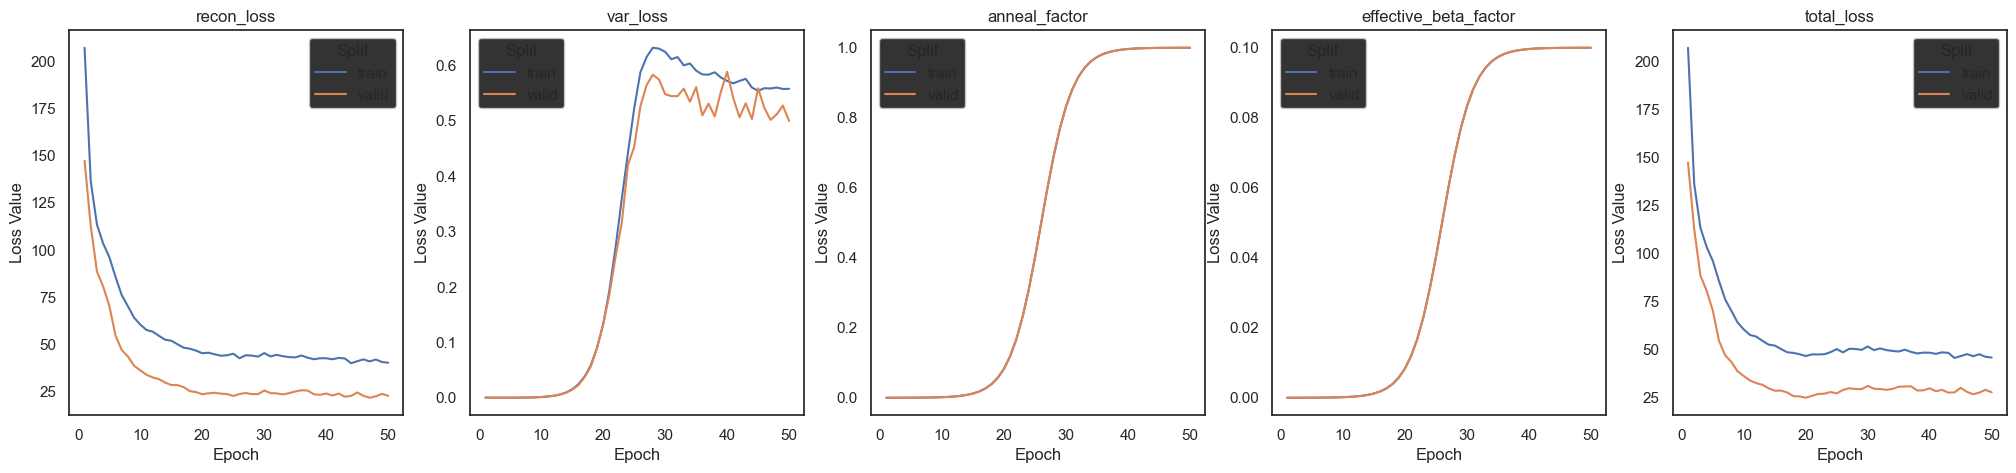

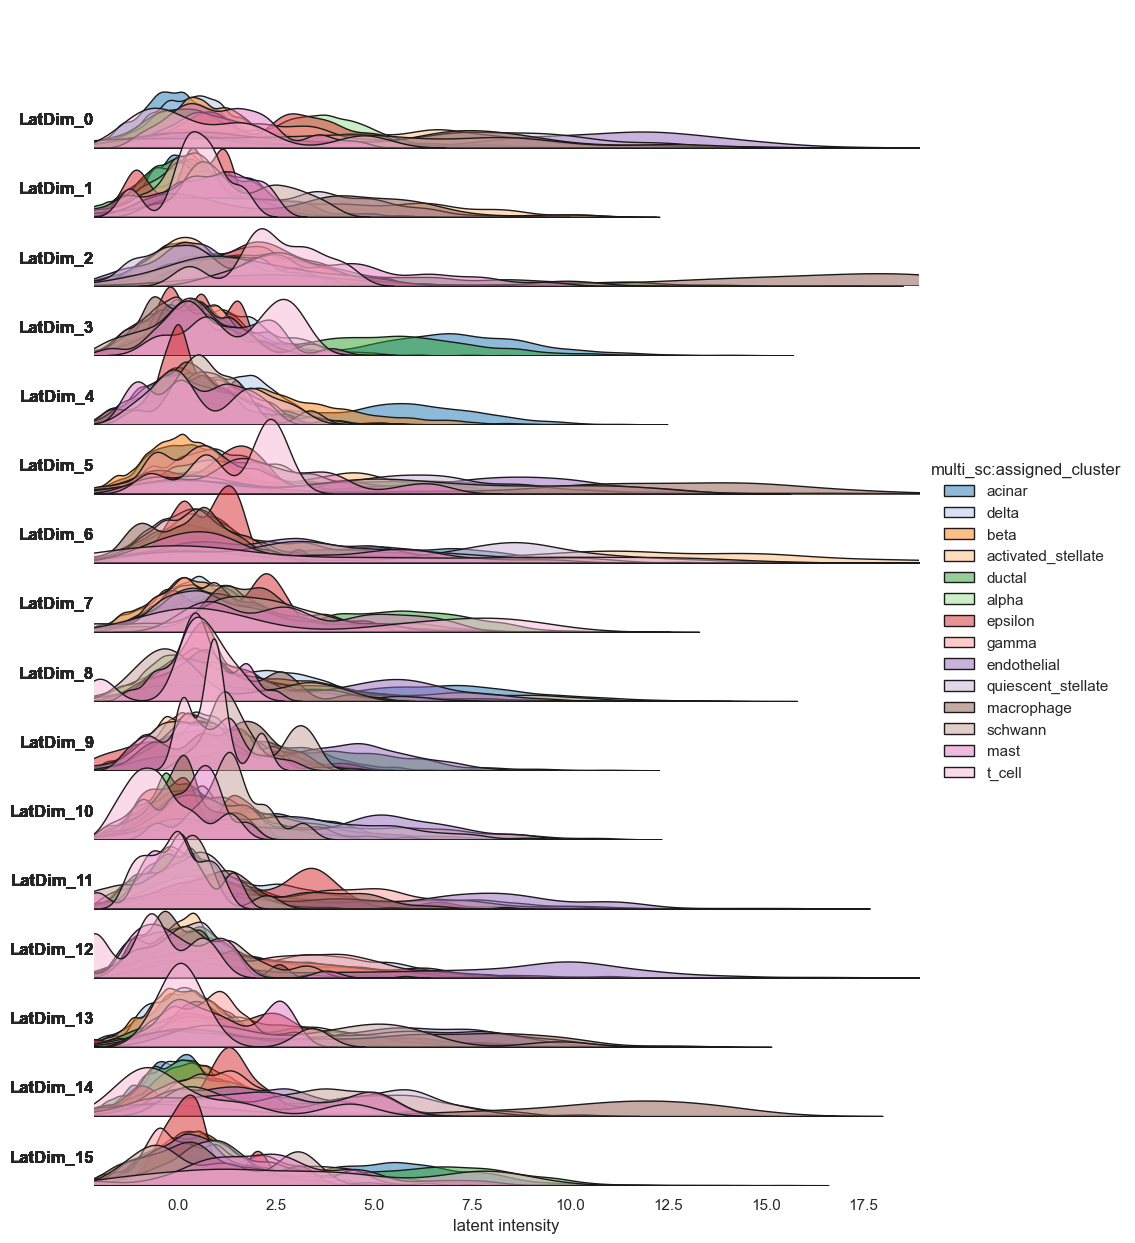

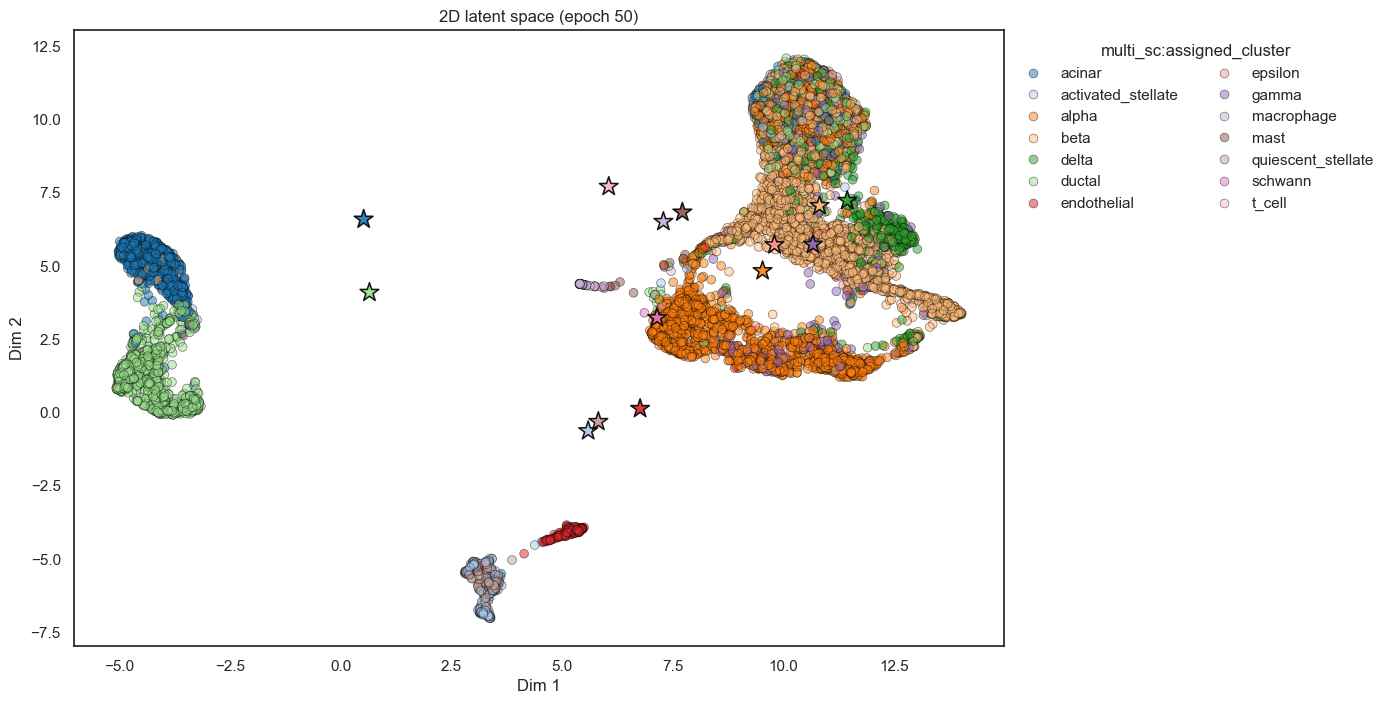

In [23]:
varix_imputed.show_result()

Creating plots ...


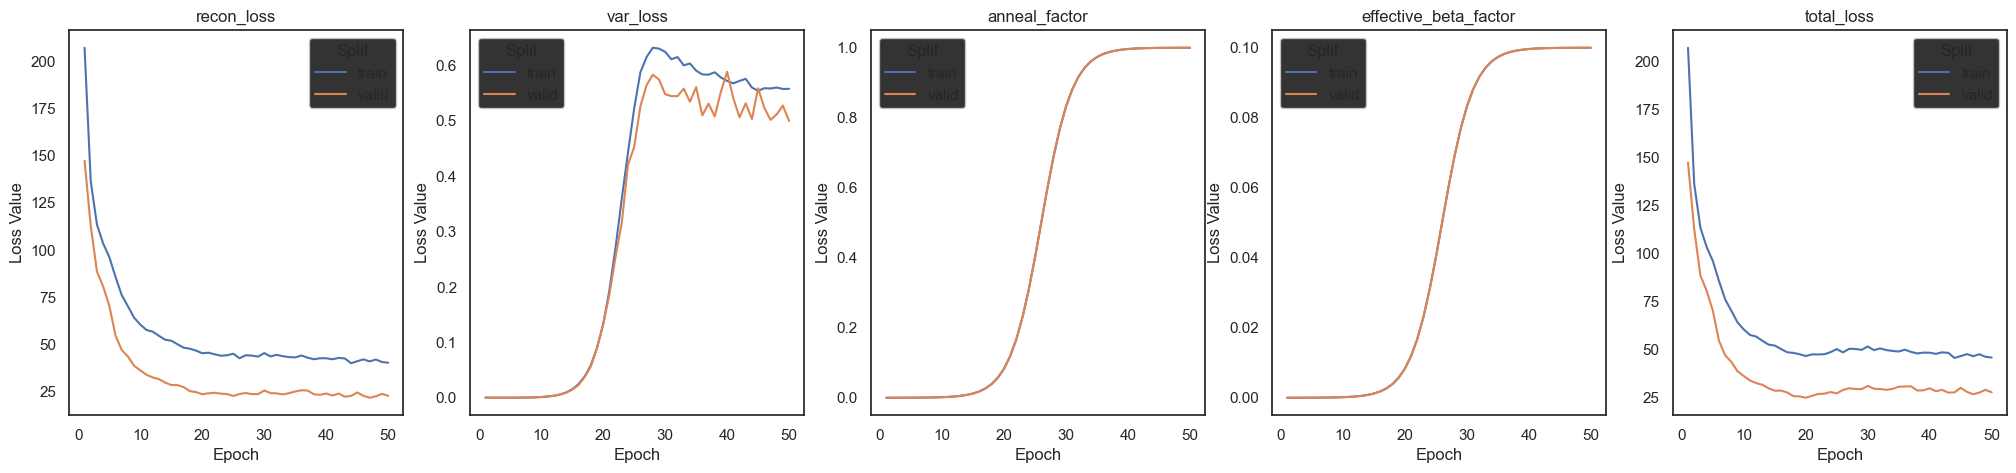

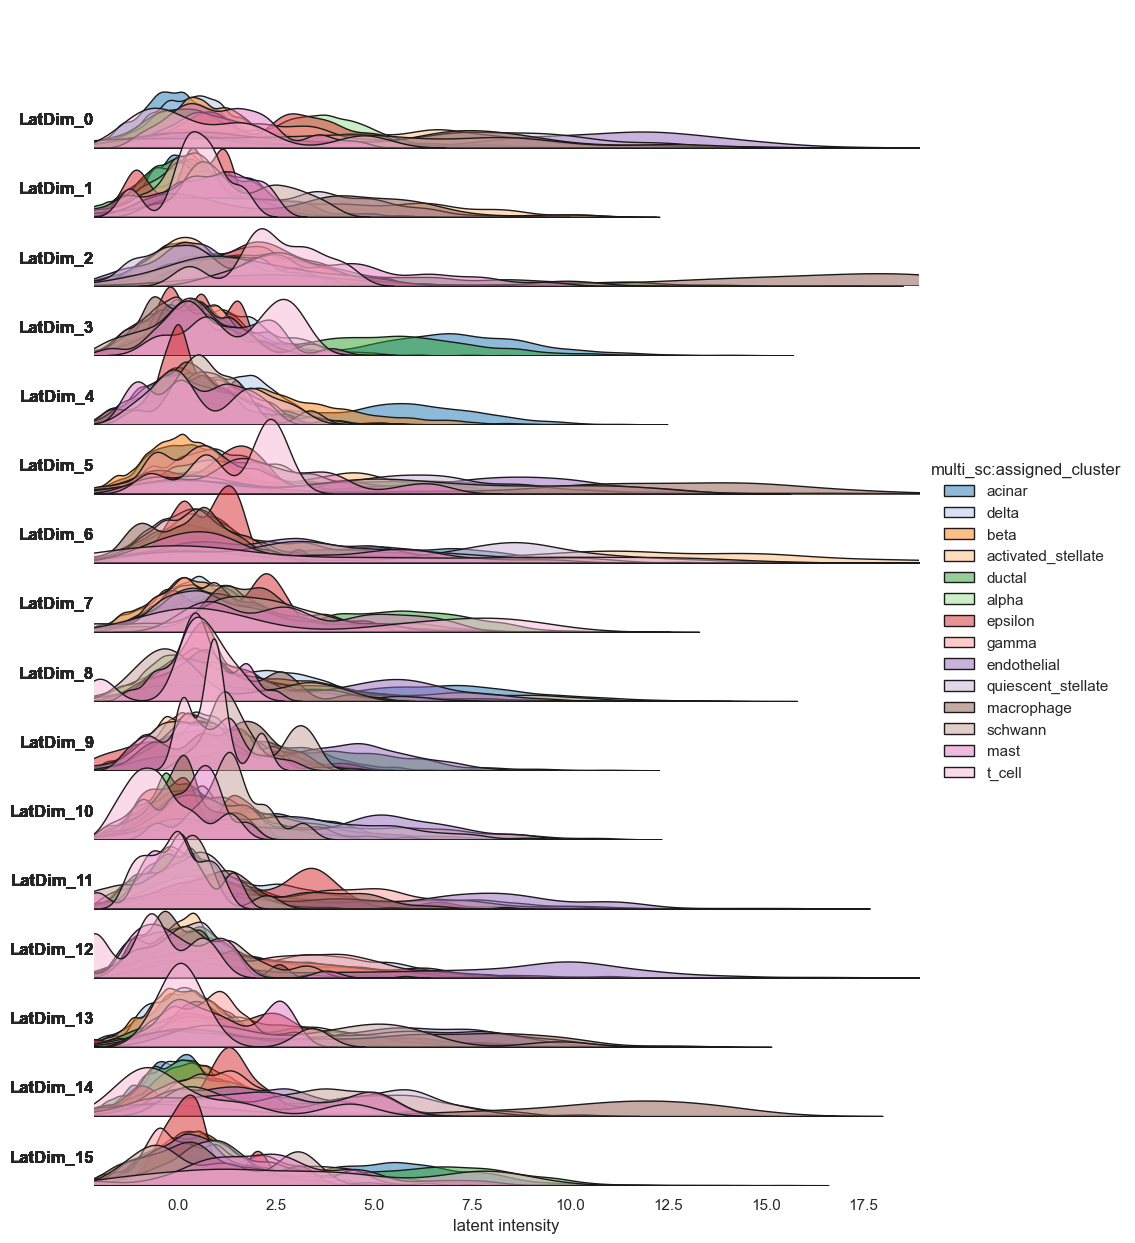

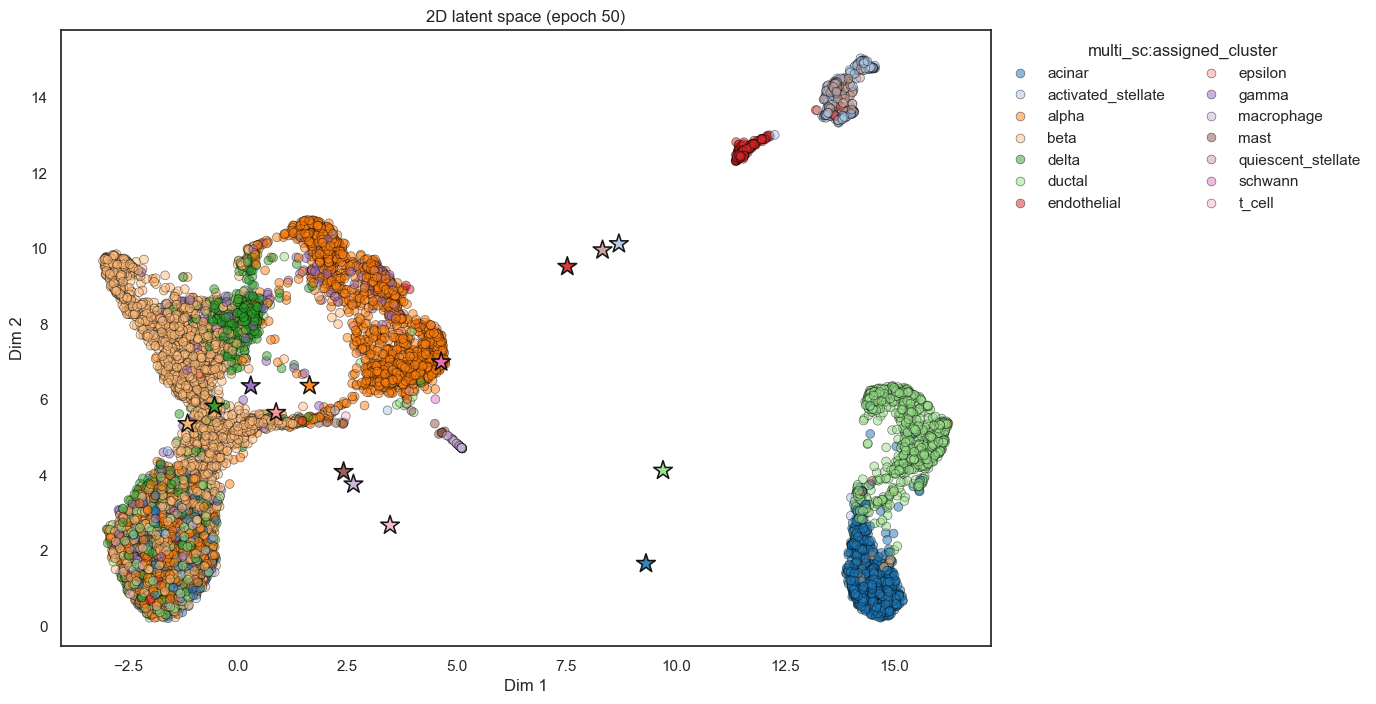

In [24]:
varix_imputed.show_result()

In [25]:
varix_imputed.evaluate()

Perform ML task with feature df: Latent
Latent
Perform ML task for target parameter: multi_sc:assigned_cluster


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_factor': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: VarixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x328969660>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x328968dc0>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x32896a890>)
new_datasets: DatasetContainer(train=None, valid=None, test=None)
adata_latent: AnnData object with n_obs × n_vars = 1715 × 16
    uns: 'var_names'
final_reconstruction: N

In [26]:
varix_missing.evaluate()

Perform ML task with feature df: Latent
Latent
Perform ML task for target parameter: multi_sc:assigned_cluster


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

Perform ML task with feature df: Latent
Latent
Perform ML task for target parameter: multi_sc:assigned_cluster


Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_factor': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: VarixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x327f1b940>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x327f1bc40>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x327f1b400>)
new_datasets: DatasetContainer(train=None, valid=None, test=None)
adata_latent: AnnData object with n_obs × n_vars = 1715 × 16
    uns: 'var_names'
final_reconstruction: N

## 7) Save, Load and Re-Use Maskix

There are not `Maskix` specific steps here. See the `Tutorials/PipelineTutorials/Vanillix.ipynb
`  or `Tutorials/DeepDives/MemoryEfficientSaving.ipynb` for details. Below is a basic save/load usecase:

Preprocessor saved successfully.
saving memory efficient
Pipeline object saved successfully.
PKL files: ['tutorial_res/ontix.pkl', 'tutorial_res/ontix_reactome.pkl', 'tutorial_res/imagix.pkl', 'tutorial_res/ontix_preprocessor.pkl', 'tutorial_res/xmodalix.pkl', 'tutorial_res/ontix_reactome_preprocessor.pkl', 'tutorial_res/xmodalix_preprocessor.pkl', 'tutorial_res/imagix_preprocessor.pkl']
Model files: ['tutorial_res/ontix_reactome_model.pth', 'tutorial_res/img.img_xmodalix_model.pth', 'tutorial_res/multi_bulk.rna_xmodalix_model.pth', 'tutorial_res/imagix_model.pth', 'tutorial_res/ontix_model.pth']
Attempting to load a pipeline from tutorial_res/maskix...
Pipeline object loaded successfully. Actual type: Maskix
Preprocessor loaded successfully.


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/losses/maskix_loss.py:38: UserWarning: You chose loss reduction: sum, this deviates from the implementation in the literature for this architecture, the authors used 'mean'
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/visualize/_general_visualizer.py:51: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: Number of columns must be a positive integer, not 0
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_pipeline.py:1000: UserWarning: No loss data found in results. Skipping loss curve visualization.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:3

Creating plots ...


<Figure size 0x500 with 0 Axes>

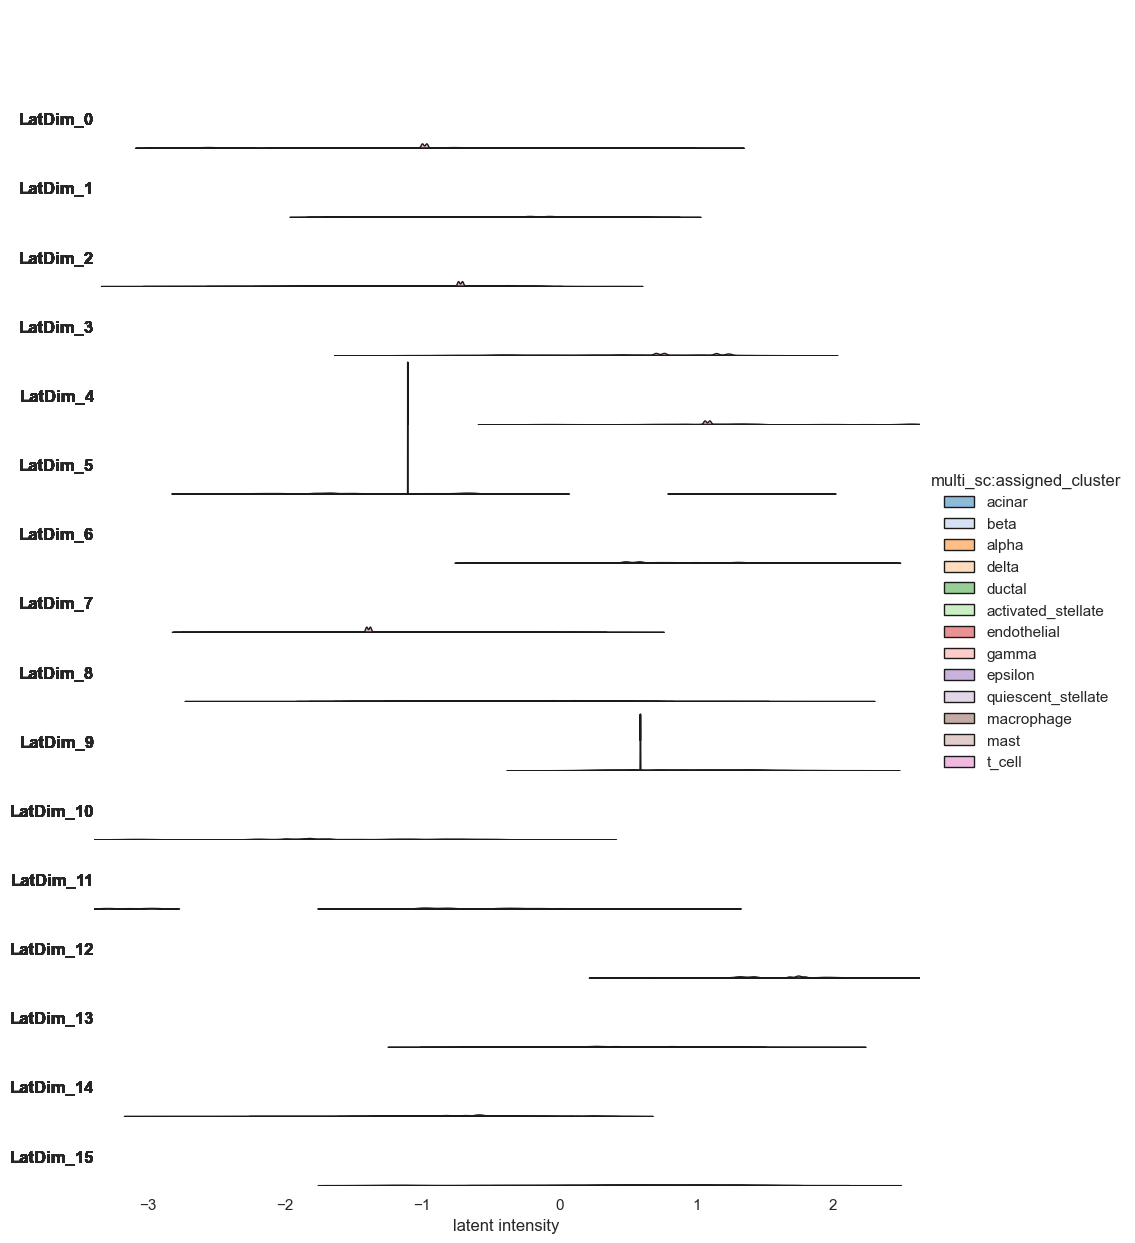

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:346: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: tuple index out of range
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:346: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: tuple index out of range
  warnings.warn(


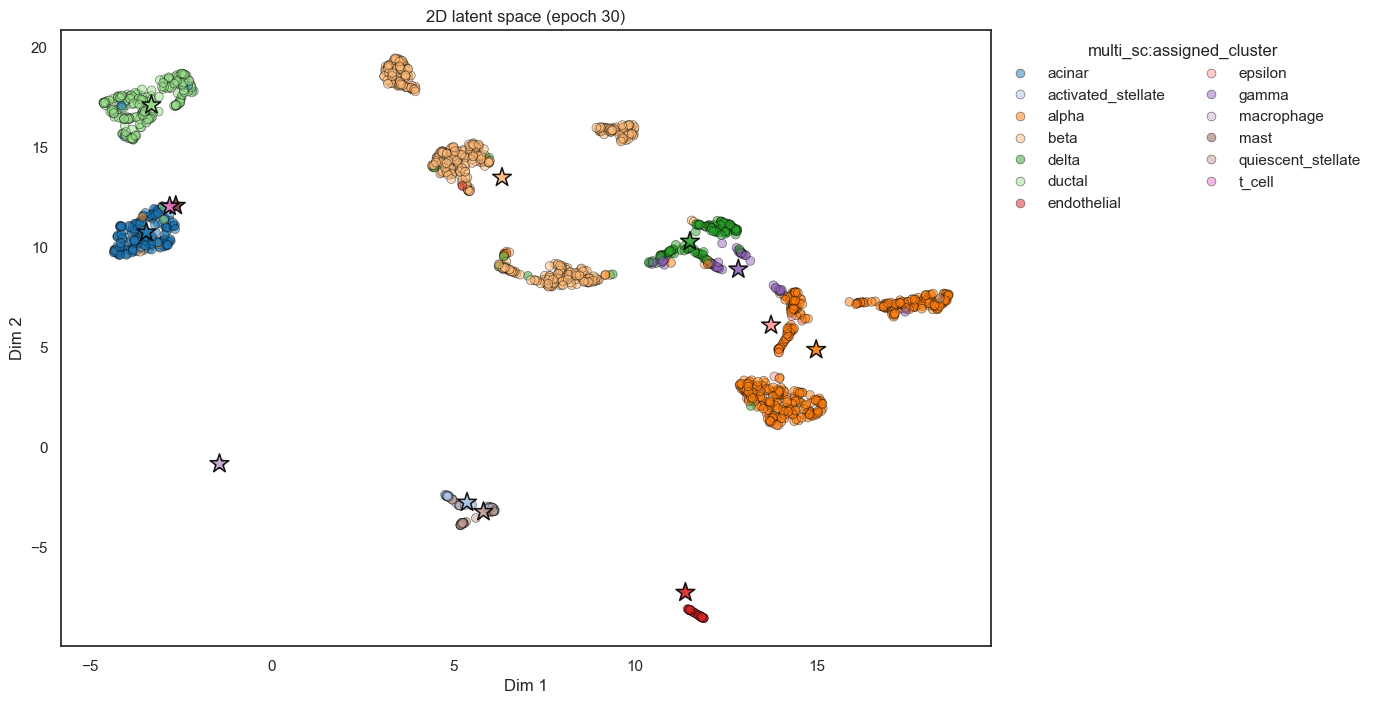

In [30]:

import os
import glob
# use a filename without extension, we handle this internally
outpath = os.path.join("tutorial_res", "maskix")
maskix.save(file_path=outpath, save_all=False)

folder = os.path.dirname(outpath)
pkl_files = glob.glob(os.path.join(folder, "*.pkl"))
model_files = glob.glob(os.path.join(folder, "*.pth"))

print("PKL files:", pkl_files)
print("Model files:", model_files)

# the load functionality automatically will build the pipeline object out of the three saved files
varix_loaded = acx.Maskix.load(outpath)
varix_loaded.predict(data=maskix_result.datasets)
varix_loaded.visualize()
varix_loaded.show_result()